<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/atomai_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders in AtomAI

Prepared by Maxim Ziatdinov (updated on December 2020)

Email: maxim.ziatdinov@ai4microscopy.com

Here we demonstrate an application of classical and rotationally-invariant variational autoencoders (VAEs) available in AtomAI for mapping structural transformations from atomically resolved images of graphene.

Install AtomAI:

In [ ]:
!pip install atomai

     |████████████████████████████████| 112kB 6.0MB/s 
     |████████████████████████████████| 194kB 15.6MB/s 
     |████████████████████████████████| 870kB 20.7MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174964 sha256=c827765ae0a1028d23b33027d2f7a99fb3b2d6d6e362554066f8a5a036240732
  Stored in directory: /root/.cache/pip/wheels/fb/28/5d/95e69a718b35dd00169889b0139a692f6c265d399cab3aa097
Successfully built mendeleev


In [ ]:
#@title Download datasets
!gdown https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
!gdown https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
!gdown https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu

Downloading...
From: https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
To: /content/3DStack13-1-dec.npy
157MB [00:01, 119MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
To: /content/3DStack13-1-exp.npy
52.4MB [00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu
To: /content/3DStack13-1-coord.npy
2.45MB [00:00, 158MB/s]


Import needed modules:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import atomai as aoi

Load raw experimental data, the semantically-segmented output from a deep neural network, and the extracted atomic coordinates:

In [ ]:
imgdata = np.load('3DStack13-1-exp.npy')
decoded_imgs = np.load('3DStack13-1-dec.npy')
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]

Plot data for the selected frame of atom-resolved movie:

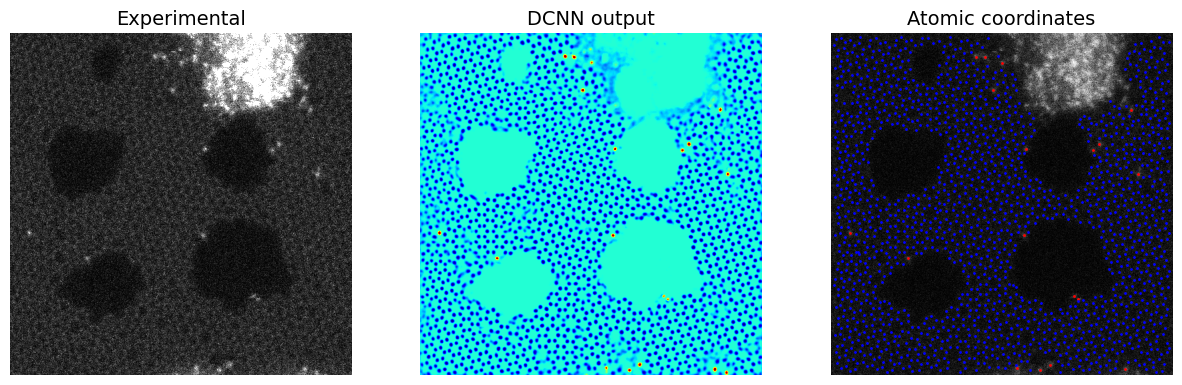

In [ ]:
i = 25 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][lattice_coord[i][:,2]==1][:,0:2]
coord_C = lattice_coord[i][lattice_coord[i][:,2]==0][:,0:2]
# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(imgdata[i,:,:,0], vmin=0, vmax=0.5, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', Interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(imgdata[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14);

The VAEs will be trained on a stack of the subimages cropped around each detected atom. Here we create the training set:

In [ ]:
window_size = 24
imstack, com_all, frames_all = aoi.utils.extract_subimages(
    np.sum(decoded_imgs[..., :-1], axis=-1), # sum all channels with atoms (Si and C)
    lattice_coord, window_size, 0)

Let's first train a conventional VAE:

In [ ]:
# Ititialize model
in_dim = (window_size, window_size)
vae = aoi.models.VAE(in_dim)
# Train
vae.fit(imstack, training_cycles=200, batch_size=200)

Epoch: 1/200, Training loss: 16.4480
Epoch: 2/200, Training loss: 11.5825
Epoch: 3/200, Training loss: 11.3733
Epoch: 4/200, Training loss: 11.1661
Epoch: 5/200, Training loss: 10.7522
Epoch: 6/200, Training loss: 10.3645
Epoch: 7/200, Training loss: 10.2139
Epoch: 8/200, Training loss: 10.1294
Epoch: 9/200, Training loss: 10.0641
Epoch: 10/200, Training loss: 10.0205
Epoch: 11/200, Training loss: 9.9732
Epoch: 12/200, Training loss: 9.9397
Epoch: 13/200, Training loss: 9.8987
Epoch: 14/200, Training loss: 9.8751
Epoch: 15/200, Training loss: 9.8376
Epoch: 16/200, Training loss: 9.8186
Epoch: 17/200, Training loss: 9.7892
Epoch: 18/200, Training loss: 9.7732
Epoch: 19/200, Training loss: 9.7555
Epoch: 20/200, Training loss: 9.7335
Epoch: 21/200, Training loss: 9.7237
Epoch: 22/200, Training loss: 9.6989
Epoch: 23/200, Training loss: 9.6897
Epoch: 24/200, Training loss: 9.6768
Epoch: 25/200, Training loss: 9.6691
Epoch: 26/200, Training loss: 9.6630
Epoch: 27/200, Training loss: 9.6514


Visualize the learned manifold:

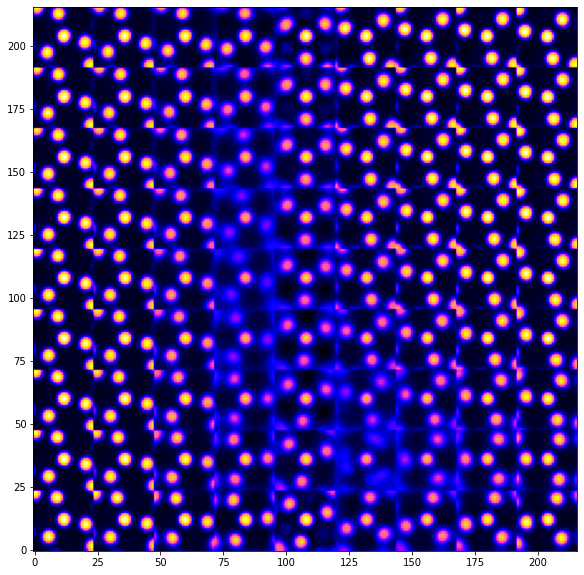

In [ ]:
vae.manifold2d(cmap="gnuplot2")

Here, the descriptors on the left and right correspond to two graphene sublattices, while those in the middle encode lateral shifts, defects, and rotations in a convoluted fashion. 

Now let's train a rotationally-invariant VAE (rVAE):

In [ ]:
# Ititialize model
in_dim = (window_size, window_size)
rvae = aoi.models.rVAE(in_dim)
# Train
rvae.fit(imstack, training_cycles=200, batch_size=200)

Epoch: 1/200, Training loss: 25.7993
Epoch: 2/200, Training loss: 23.8731
Epoch: 3/200, Training loss: 23.6056
Epoch: 4/200, Training loss: 22.3000
Epoch: 5/200, Training loss: 20.5527
Epoch: 6/200, Training loss: 19.1711
Epoch: 7/200, Training loss: 18.4172
Epoch: 8/200, Training loss: 17.6792
Epoch: 9/200, Training loss: 16.9780
Epoch: 10/200, Training loss: 16.2702
Epoch: 11/200, Training loss: 15.3189
Epoch: 12/200, Training loss: 14.1096
Epoch: 13/200, Training loss: 12.9272
Epoch: 14/200, Training loss: 12.2667
Epoch: 15/200, Training loss: 11.8457
Epoch: 16/200, Training loss: 11.5825
Epoch: 17/200, Training loss: 11.3806
Epoch: 18/200, Training loss: 11.2342
Epoch: 19/200, Training loss: 11.1199
Epoch: 20/200, Training loss: 10.9981
Epoch: 21/200, Training loss: 10.9085
Epoch: 22/200, Training loss: 10.8409
Epoch: 23/200, Training loss: 10.7669
Epoch: 24/200, Training loss: 10.7109
Epoch: 25/200, Training loss: 10.6685
Epoch: 26/200, Training loss: 10.6206
Epoch: 27/200, Traini

Visualize the learned manifold:

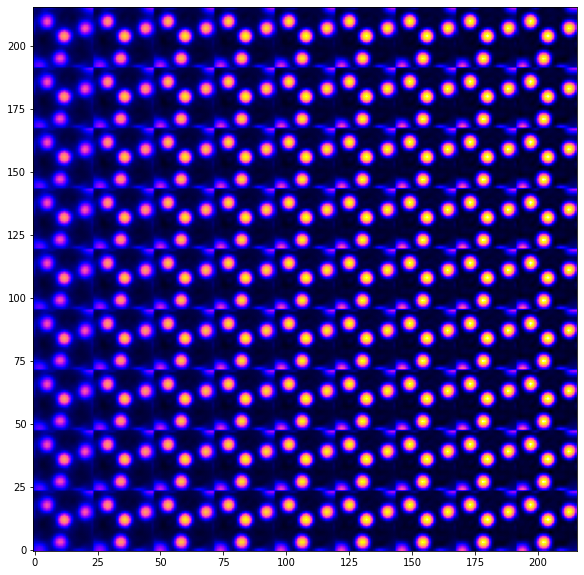

In [ ]:
rvae.manifold2d(cmap="gnuplot2")

Since rotational variation is effectively removed from elementary descriptors, remaining variations within data can be described much more efficiently than with the regular VAE.

Now let's encode the entire image stack (our movie). Here the first latent variable is associated with rotation, the second and third ones are associated with translations in *x* and *y* directions, and the latent variables starting from the third one correspond to images content.

In [ ]:
z_mean, z_sd = rvae.encode(imstack)
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

Plot distributions of "structural" latent variables (angle and translations):

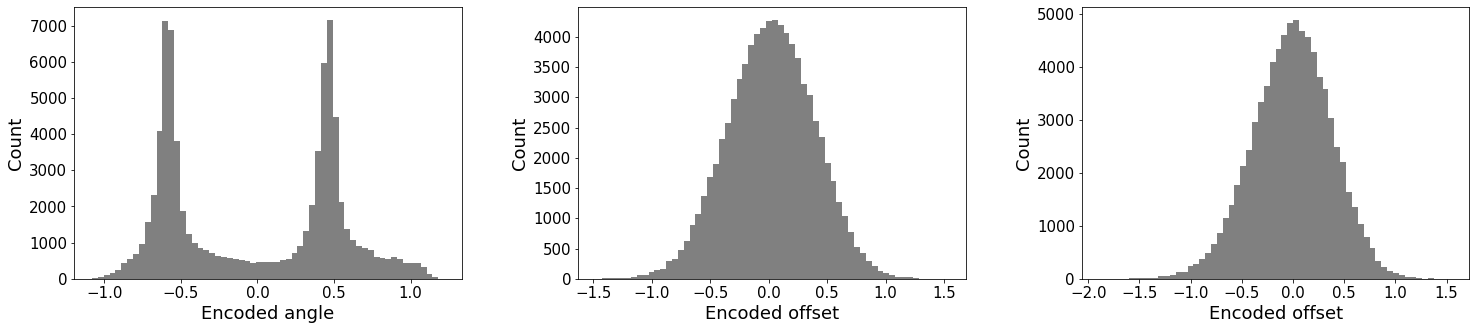

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='gray')
ax[1].hist(z2[:, 0], bins=60, color='gray')
ax[2].hist(z2[:, 1], bins=60, color='gray')
ax[0].set_xlabel("Encoded angle", fontsize=18)
ax[1].set_xlabel("Encoded offset", fontsize=18)
ax[2].set_xlabel("Encoded offset", fontsize=18)
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

Finally we map the encoded values associated with the subimages (encoded angle and latent variables associated with images content) onto the original movie frames:

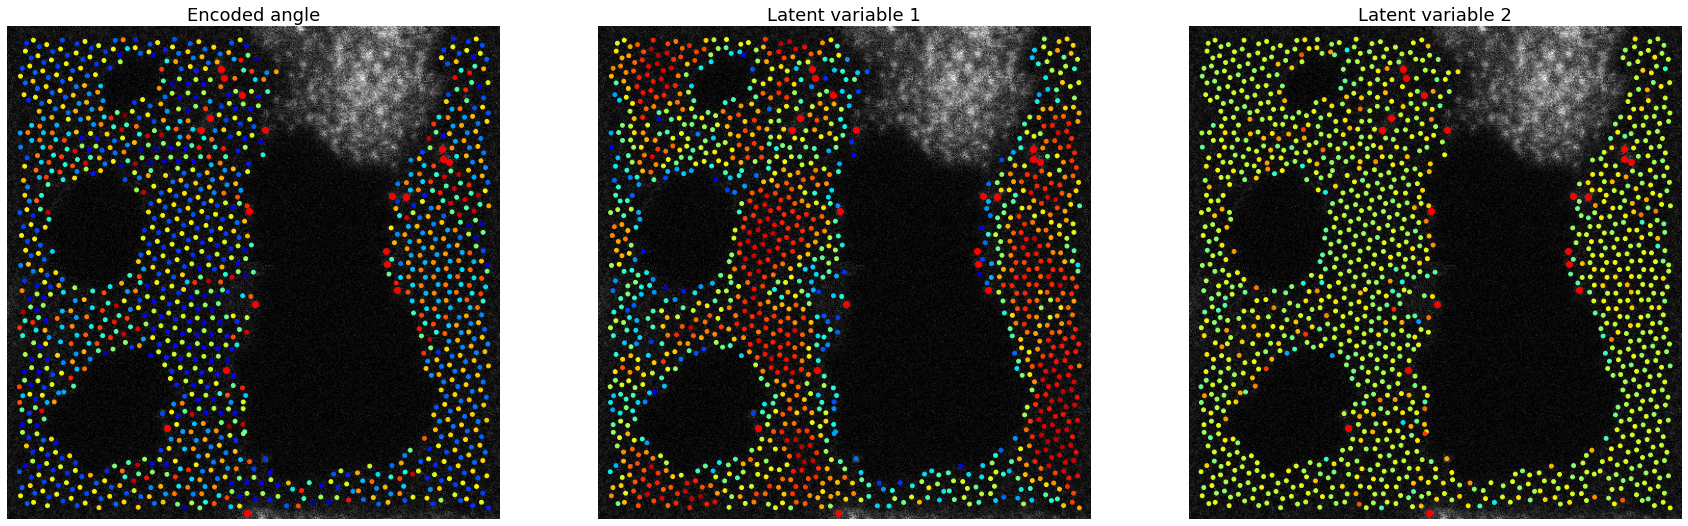

In [ ]:
frame = 49 # select frame

com_i = com_all[frames_all == frame] # get coordinates for this frame
com_i_Si = lattice_coord[frame] # get Si coordinates for plotting
com_i_Si = com_i_Si[com_i_Si[:,-1]==1.]
z1_i = z1[frames_all == frame] # get latent variables (image) for this frame
z3_i = z3[frames_all == frame] # get latent variables (image) for this frame

col_min0 = z1.min()
col_max0 = z1.max()
col_min1 = z3[:, 0].min()
col_max1 = z3[:, 0].max()
col_min2 = z3[:, 1].min()
col_max2 = z3[:, 1].max()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(imgdata[frame,...,0], cmap="gray")
ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
            cmap="jet", vmin=col_min0, vmax=col_max0)
ax[0].set_title("Encoded angle", fontsize=18)
ax[1].imshow(imgdata[frame,...,0], cmap="gray")
ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
            cmap="jet", vmin=col_min1, vmax=col_max1)
ax[1].set_title("Latent variable 1", fontsize=18)
ax[2].imshow(imgdata[frame,...,0], cmap="gray")
ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
              cmap="jet", vmin=col_min2, vmax=col_max2)
ax[2].set_title("Latent variable 2", fontsize=18)
for _ax in fig.axes:
    _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
    _ax.axis(False)
plt.show()

Here, the color scale of each atomic unit is set according
to the value of the corresponding latent variable for angle (first image) and first two latent variable associated with images content (second and third images). The angle variable shows clear contrast for the two structurally unique sublattice positions in the graphene lattice, giving rise to the checkerboard-like pattern. Small angle boundaries and the rotation between graphene fragments are clearly visible. At the same time, the behavior of the second latent variable corresponding to the content of sub-images clearly shows that it adopts maximum value in the well-ordered regions and is reduced at the edges and in regions with high defect density, allowing for its interpretation as local crystallinity. 